In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys

import os
import datetime
import glob
import h5py

sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import astropy.coordinates as coord
import astropy.time as atime
import astropy.units as u

import jabble.quickplay
import jabble.loss
import jabble.dataset
import jabble.model
import jabble.physics

# from jax.config import config

jax.config.update("jax_enable_x64", True)

/home/mdd423/wobble_jax/notebooks/../jabble/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
files = glob.glob('/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-3/*.fits',recursive = True)

In [4]:
hdu1 = fits.open(files[0])

In [59]:
hdu1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              5010272 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = '313142D '                                                            
EXTNAME = 'SPECTRUM'           / Extension Name                                 
DATASUM = '1250708763'         / data unit checksum updated 2014-09-17T01:06:36 
TTYPE2  = 'FLUX    '        

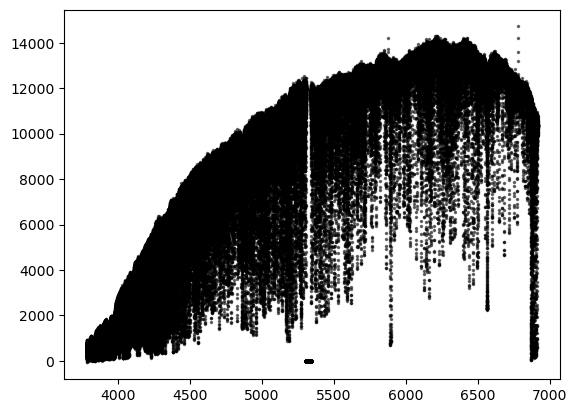

In [6]:
plt.errorbar(hdu1[1].data["WAVE"][0,:],hdu1[1].data["FLUX"][0,:],hdu1[1].data["ERR"][0,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
plt.show()

In [7]:
import astropy.time as at
import astropy.coordinates as acoord
import astropy.units as u
import sys
sys.path.append('..')
import jabble.dataset

In [8]:
def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping

    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do

    Returns:
        The value of the continuum at the wavelengths in x

    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w,_,_,_ = np.linalg.lstsq(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

In [9]:
def get_dataset(files,device,index_1=0,index_2=4000):
    ys = []
    xs = []
    yivar = []
    mask = []

    bcs = []
    airmass = []
    times = []
    star_ids = []

    # fig, axes = plt.subplots(3,figsize=(9,9))
    for file in files:
        with fits.open(file) as hdu:
            flux = np.log(np.array(hdu[1].data["FLUX"][0,index_1:index_2]))
            wave = np.log(np.array(hdu[1].data["WAVE"][0,index_1:index_2]))
            err  = np.array(hdu[1].data["ERR"][0,index_1:index_2])/np.array(hdu[1].data["FLUX"][0,index_1:index_2])
            err[np.isnan(err)] = 1/hdu[0].header['SNR']
            ma = np.isnan(err) | np.isinf(err) | np.isinf(flux) | (flux <= 0.0) | np.isnan(flux)
            # clean this shit
            flux[ma] = 0.0
            info = 1/err**2
            info[ma] = 0.0
            wave[ma] = np.min(wave)
            # print(np.sum(np.isnan(flux[~ma])),np.sum(ma))
            # print(np.sum(flux[~ma]),np.sum(err[~ma]),np.sum(wave[~ma]))
            contin = fit_continuum(wave,flux,\
                                   1/err**2,\
                                   order=6, nsigma=[0.3,3.0], maxniter=50)
            
            ys.append(flux - contin)
            
            # plt.errorbar(wave,contin,err,fmt='.r',elinewidth=1.2,zorder=2,alpha=0.5,ms=3)
            
            
            xs.append(wave)
            yivar.append(1/err**2)
            mask.append(ma.astype(bool))
            times.append(hdu[0].header["MJD-OBS"])

            harps = acoord.EarthLocation.of_site("La Silla Observatory")
            sc    = acoord.SkyCoord(ra=hdu[0].header["RA"]*u.deg, dec=hdu[0].header["DEC"]*u.deg)
            barycorr = sc.radial_velocity_correction(obstime=at.Time(hdu[0].header["MJD-OBS"],format='mjd'), location=harps)

            # axes[0].errorbar(wave - jabble.physics.shifts(barycorr.to(u.m/u.s).value),flux - contin,err,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=2)
            # axes[1].errorbar(wave,flux - contin,err,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=2)
            # axes[2].errorbar(wave + jabble.physics.shifts(barycorr.to(u.m/u.s).value),flux - contin,err,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=2)
            
            
            bcs.append(barycorr.to(u.m/u.s).value)
            
            try:
                
                airmass.append(hdu[0].header["AIRMASS"])
            except KeyError:
                altz = sc.transform_to(acoord.AltAz(obstime=at.Time(hdu[0].header["MJD-OBS"],format='mjd'),location=harps))

                airmass.append(altz.secz)
            star_ids.append(str(file))
    # plt.show()
    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)
    
    dataset.metadata['times']    = jnp.array(times)
    dataset.metadata['star_ids'] = np.array(star_ids)
    dataset.metadata['bcs']      = jnp.array(bcs)
    dataset.metadata['airmass']  = jnp.array(airmass)
    dataset.to_device(device)
    
    # init_shifts = jax.device_put(init_shifts,device)
    # airmass = jax.device_put(airmass,device)
    
    return dataset

In [11]:
cpus = jax.devices("cpu")

In [12]:
dataset = get_dataset(files,cpus[0],0,5000)

/state/partition1/job-62214681/ipykernel_3440835/4275750135.py:15: RuntimeWarning: invalid value encountered in log
  flux = np.log(np.array(hdu[1].data["FLUX"][0,index_1:index_2]))
/state/partition1/job-62214681/ipykernel_3440835/3111554450.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w,_,_,_ = np.linalg.lstsq(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))


In [13]:
out_dir

'../out/25-06-17'

In [14]:
# # bcs = [jabble.physics.get_star_velocity(time,hdu1[0].header['OBJECT'],'La Silla Observatory (ESO)').to(u.m/u.s).value for time in mjds]
# plt.plot([mjd%365 for mjd in mjds],bcs,'.k')
# plt.title('18 Scorpii')
# plt.ylabel('BCS')
# plt.xlabel('MJD mod 365')
# plt.savefig(os.path.join(out_dir,'04-18sco-rv-mjd.png'))
# plt.show()

In [15]:
460*np.cos(29/360*2*np.pi)

402.32506528412205

In [16]:
# plt.errorbar(xs[0],ys[0],1/np.sqrt(yi[0]),fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

In [17]:
def get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_vels,airmass):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    # model = jabble.quickplay.get_wobble_model(init_rvs, airmass, model_grid, p_val,rest_vels) #+ jabble.quickplay.get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model = jabble.quickplay.PseudoNormalModel(init_shifts, init_airmass, model_grid, p_val, dataset, norm_p_val, pts_per_wavelength)
    init_shifts = jabble.physics.shifts(init_rvs)
    rest_shifts = jabble.physics.shifts(rest_vels)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts,which_key='times'),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts,which_key='times'),
            jabble.model.CardinalSplineMixture(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    ) #+ jabble.model.get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [18]:
def train_cycle(model, dataset, loss, lmb, device_store, device_op, batch_size):
    options = {"maxiter": 4096}
    
    # Fit Normalization Template
    # model.fix()
    # model.fit(2, 1)
    # # model.fit(0,1)
    # # model.fit(1,1)
    # # model.display()
    
    
    # res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    # print(res1)

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0,1)
    model.fit(1,1)
    model.display()
    
    res1 = model.optimize(loss + reg_s + reg_t, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0,0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # shift_search = jabble.physics.shifts(np.linspace(-50, 50, 100))
    # model[0][0].parabola_fit(shift_search, loss, model, dataset, device_op, device_store)
    # model.to_device(device_op)
    # print(type(model_p[0][0].p))

    # Fit Everything
    model.fix()
    model.fit(0,0)
    model.fit(0,1)
    model.fit(1,1)

    res1 = model.optimize(loss + reg_s + reg_t, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [19]:
resolution = 115_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb = 1000.0

total_pixels = len(np.array(hdu1[1].data['WAVE']).flatten())
pixels_per_chunk = 4000

star_name = 'sco18'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)


In [20]:
total_pixels//pixels_per_chunk,total_pixels%pixels_per_chunk

(78, 1142)

In [21]:
# wave = [np.linspace(0,1)]*3
# flux = [np.linspace(0,1)]*3
# mask = [np.ones(flux[0].shape)]*3
# yivar = [np.ones(flux[0].shape)]*3

# testset = jabble.dataset.Data.from_lists(wave,flux,yivar,mask)
# datablock,metablock = testset.blockify(cpus[0])
# datarow = jabble.loss.dict_ele(datablock,0,device_op)
# metarow = jabble.loss.dict_ele(metablock,0,device_op)

# testmodel = jabble.model.CardinalSplineMixture(wave[0], 2)
# testmodel.fit()

# loss = jabble.loss.ChiSquare()
# pred = loss(testmodel.get_parameters(),datarow,metarow,testmodel)
# print(pred.sum())

<h1>BIG PROBLEM DIFFERENCE BETWEEN MIN AND MAX BCS IS LESS THAN THE INSTRUMENT RESOLUTION</h1>
Or just barely greater than that but still not very good

In [66]:
l_index= 249200
h_index = l_index + 1500
print(hdu1[1].data['WAVE'][0][l_index],hdu1[1].data['WAVE'][0][h_index])
print(np.log(hdu1[1].data['WAVE'][0][h_index]/hdu1[1].data['WAVE'][0][l_index])/jabble.physics.shifts(60_000))
print(jabble.physics.shifts(np.max(dataset.metadata['bcs']) - np.min(dataset.metadata['bcs'])))
print(jabble.physics.delta_x(115_000))

6273.51 6288.51
11.9324995693568
7.959225992397781e-05
8.695614366909276e-06


In [63]:
hdu1[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
DATASUM = '0       '           / data unit checksum updated 2014-09-17T01:06:36 
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   
DATE    = '2010-09-15T18:08:33.493' / Date this file was written                
INSTRUME= 'HARPS   '           / Instrument used                                
RA      =           243.902060 / 16:15:36.4 RA (J2000) pointing                 
DEC     =             -8.37055 / -08:22:13.9 DEC (J2000) pointing               
EQUINOX =                2000. / Standard FK5 (years)                           
RADECSYS= 'FK5     '        

In [55]:
device_store = cpus[0]
device_op = cpus[0]
batch_size = 5000

# for round_i in range(total_pixels//pixels_per_chunk):
#     l_index = round_i*pixels_per_chunk
#     h_index = np.min(((round_i+1)*pixels_per_chunk,total_pixels))
    
data_name = os.path.join(out_dir,star_name,'{}_data_p{}-{}_-bc.pkl'.format(star_name,l_index,h_index))
model_name = os.path.join(out_dir,star_name,'{}_model_p{}-{}_-bc.pkl'.format(star_name,l_index,h_index))
dataset = get_dataset(files,device_op,l_index,h_index)

init_rvs = jnp.zeros(dataset.metadata['bcs'].shape)
rest_rvs = -dataset.metadata['bcs']


model = get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,dataset.metadata['airmass'])

reg_s = lmb*jabble.loss.L2Reg([0,1])
reg_t = lmb*jabble.loss.L2Reg([1,1])

loss = jabble.loss.ChiSquare()

model = train_cycle(model, dataset, loss + reg_s + reg_t, lmb, device_store, device_op, batch_size)
jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss+reg_s+reg_t)


/state/partition1/job-62214681/ipykernel_3440835/3111554450.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w,_,_,_ = np.linalg.lstsq(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))


-AdditiveModel--------------------------------------------------1426
  0-CompositeModel-----------------------------------------------713
  0  0-ShiftingModel-----------------------------------------------0
  0  1-CardinalSplineMixture-------------------------------------713
  1-CompositeModel-----------------------------------------------713
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture-------------------------------------713
  1  2-StretchingModel---------------------------------------------0
{'grad': array([0., 0., 0., ..., 0., 0., 0.]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 112, 'nit': 106, 'warnflag': 0}
{'grad': array([ 3.42471141e+02, -3.98564429e+05, -1.05145218e+05, -8.32458380e+05,
       -5.87692203e+05,  1.97555825e+04,  3.84736994e+05,  3.38402619e+05,
       -7.09289017e+05, -4.44334306e+04, -1.87820050e+05, -5.26885426e+04,
        1.68304775e+04,  1.67835743e+04,  2.71562404e+04,  8.674

[[6275. 6277. 6279. 6281. 6283.]
 [6275. 6277. 6279. 6281. 6283.]
 [6275. 6277. 6279. 6281. 6283.]
 [6275. 6277. 6279. 6281. 6283.]]


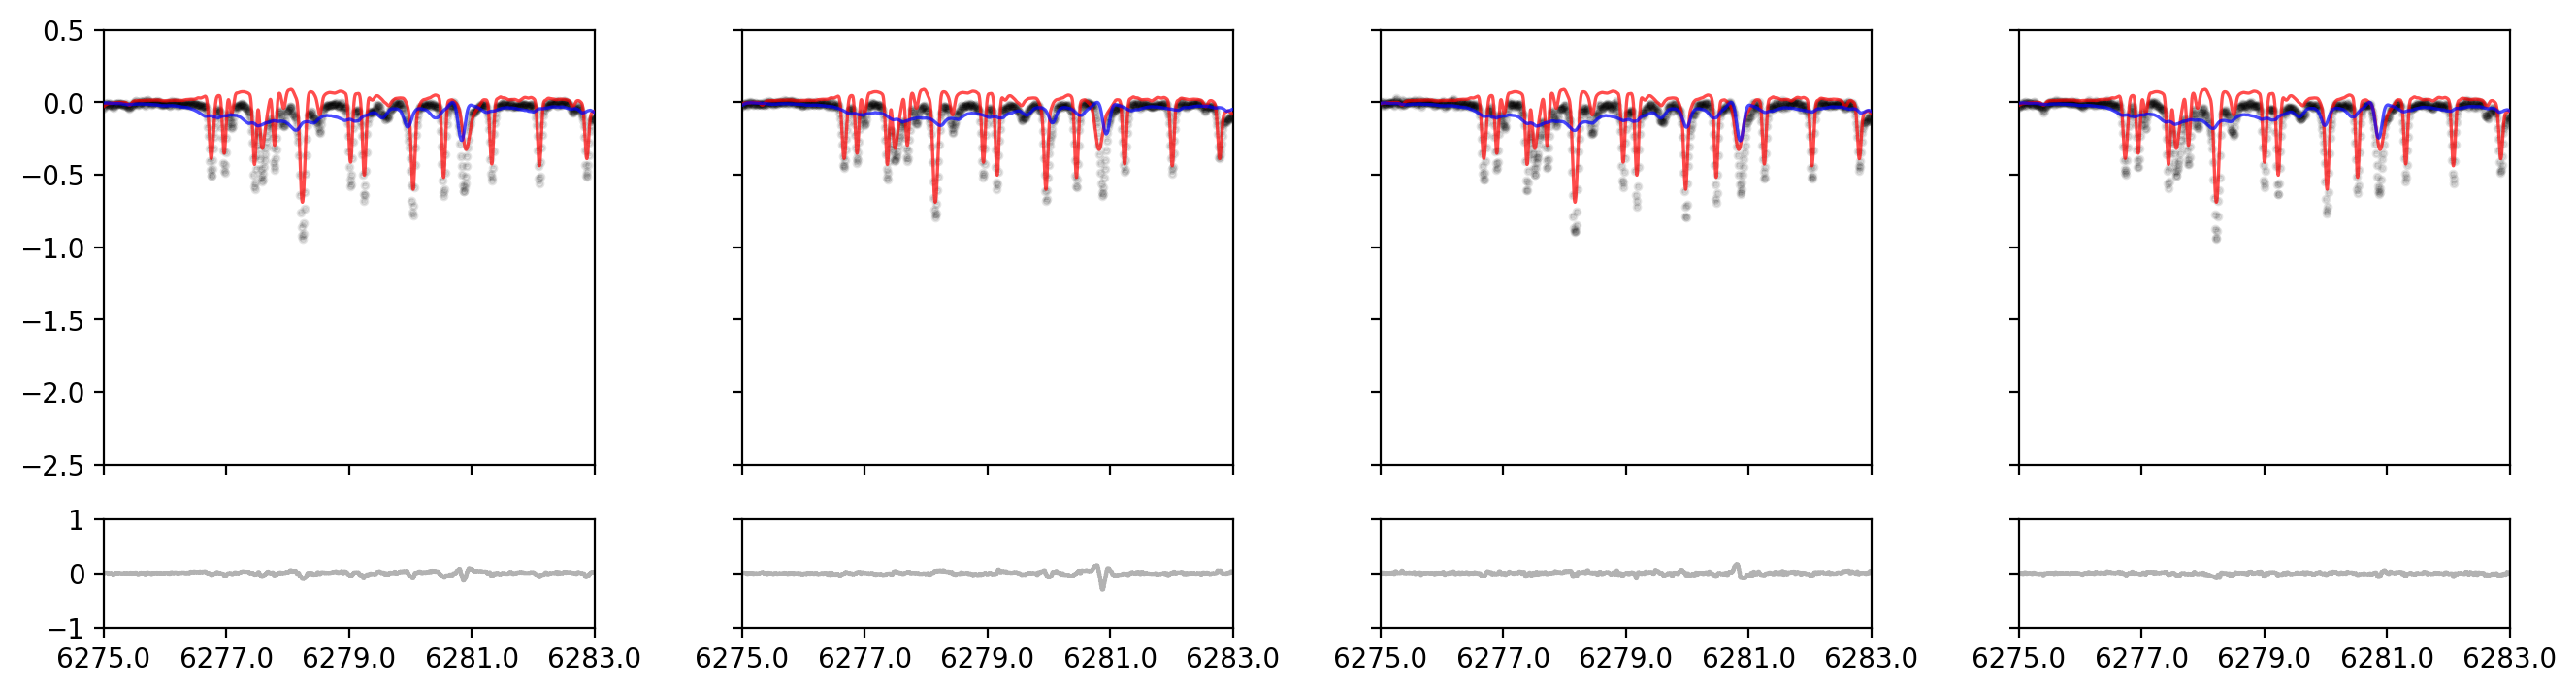

In [58]:
rv_inds = [-1,0,1,2]
l_plt = 6280
lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-5,5,2)[None,:]
# print(lrange)
# lrange = np.repeat(lrange,len(rv_inds),axis=0) + np.zeros(len(rv_inds))[:,None]
plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
print(lrange)
jabble.plotting.make_order_plot(dataset,model,lrange,rv_inds,cpus[0],plt_name)
#(dataset,model,lrange,rv_inds,device,plt_name=None)

In [23]:
import glob
import jabble.plotting
import cmasher

In [24]:
summary_path = "/scratch/mdd423/wobble_jax/out/25-06-06/sco18"
dir_files = glob.glob(os.path.join(summary_path,'*_RVS.hdf'))
print(len(dir_files))

76


In [25]:
rv_array, all_models, all_rv_array, all_data = jabble.quickplay.load_model_dir(summary_path,dir_files,cpus[0],force_run=True)

3338.257497672205
61.15672993565593


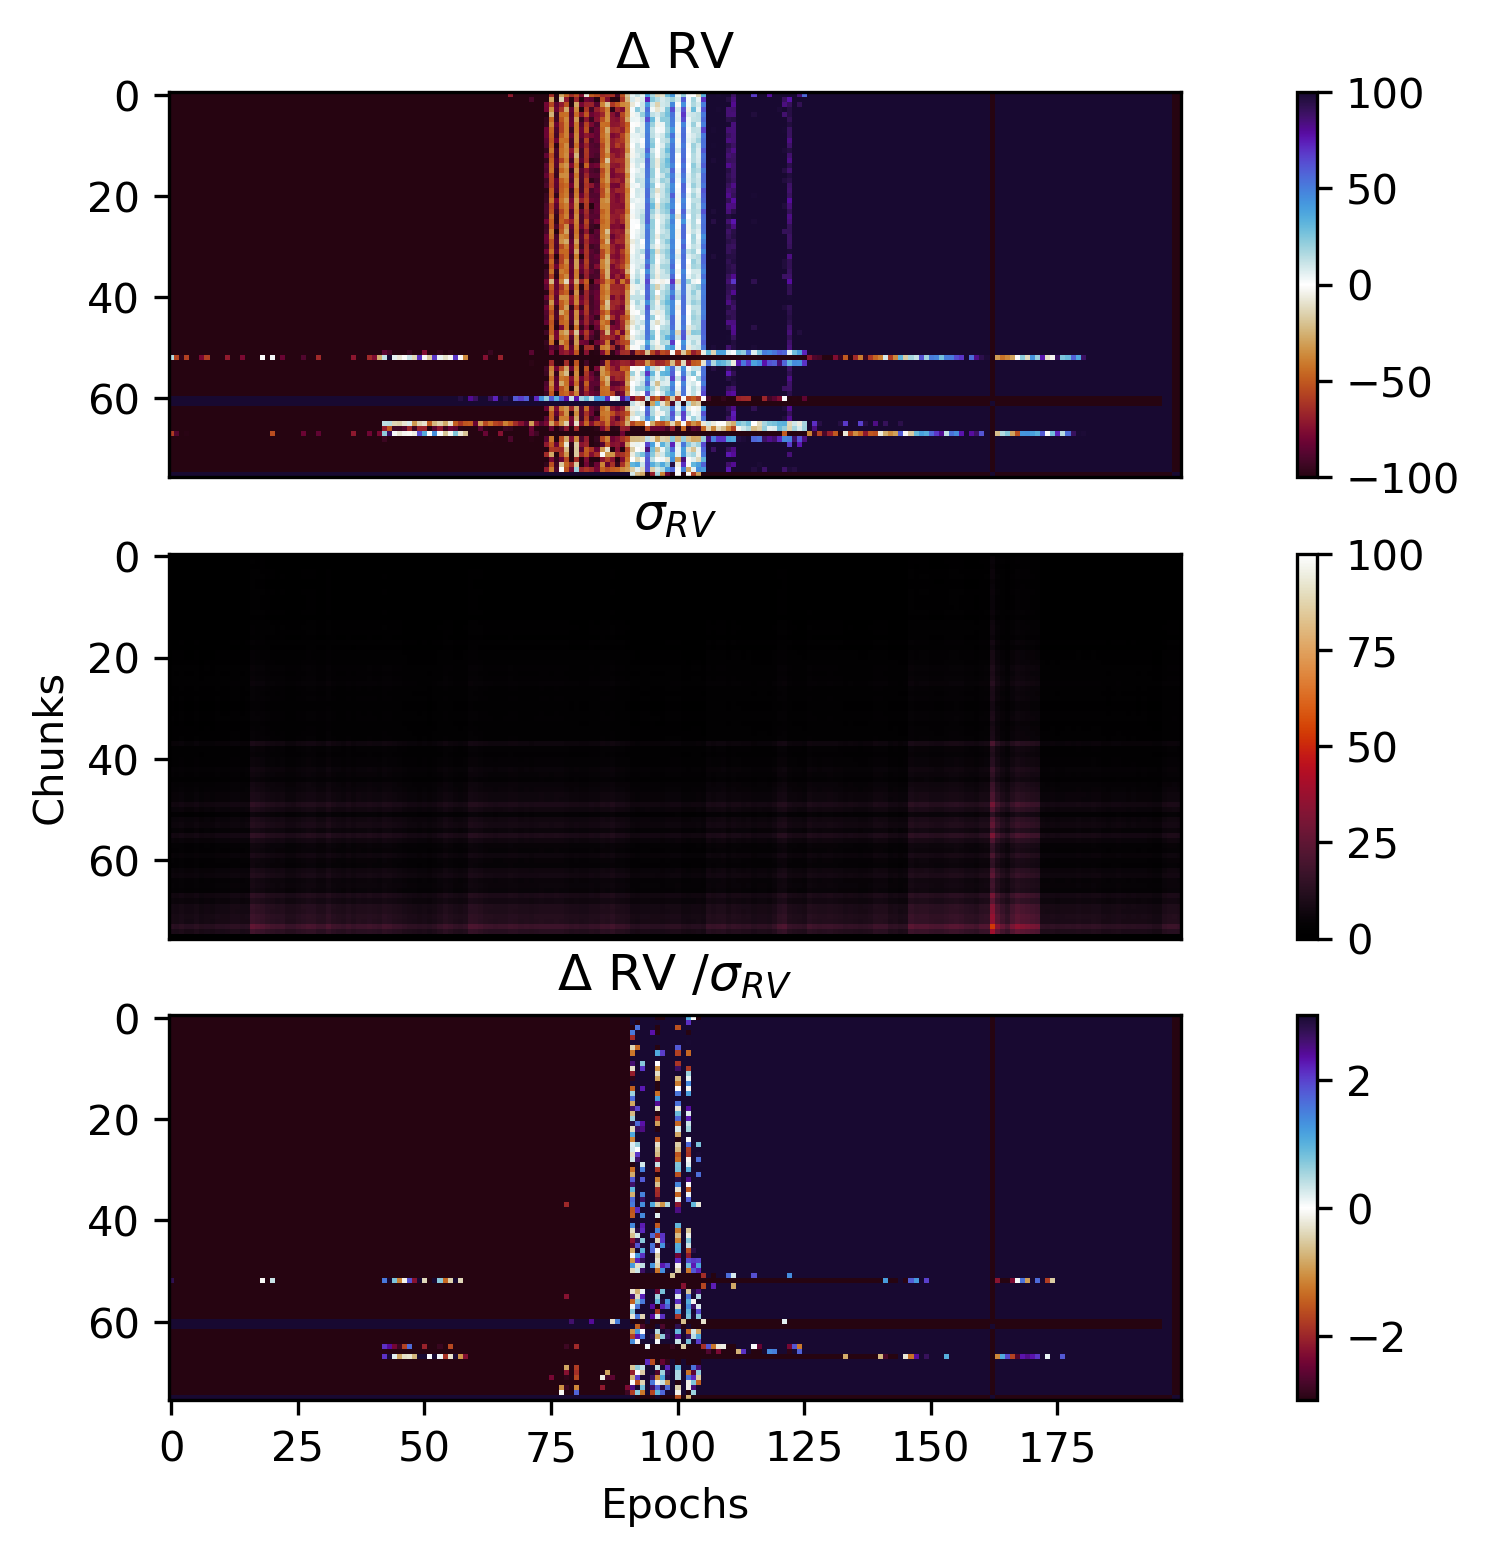

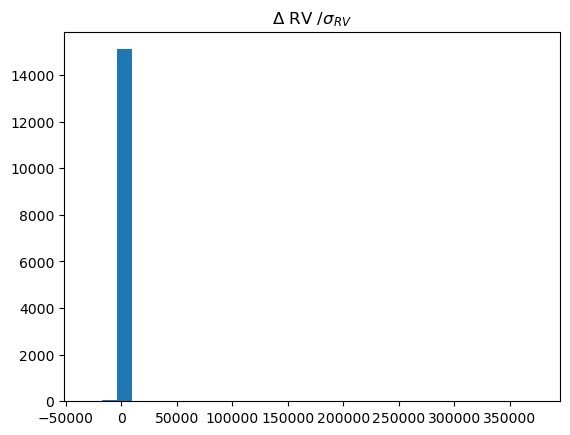

In [26]:
jabble.plotting.plot_rv_difference(all_rv_array['Time_all'],all_rv_array['RV_all'],all_rv_array['RV_err_all'],\
                        rv_array['Time_comb'],rv_array['RV_comb'],rv_array['RV_err_comb'],\
                        dataset.metadata['times'],dataset.metadata['bcs'],np.zeros(dataset.metadata['bcs'].shape),\
                        dataset.metadata['bcs'],all_rv_array['Loss_Avg'],all_rv_array['RV_difference'],star_name,\
                                   out_dir=out_dir,sigma_max=100,difference_max=100)

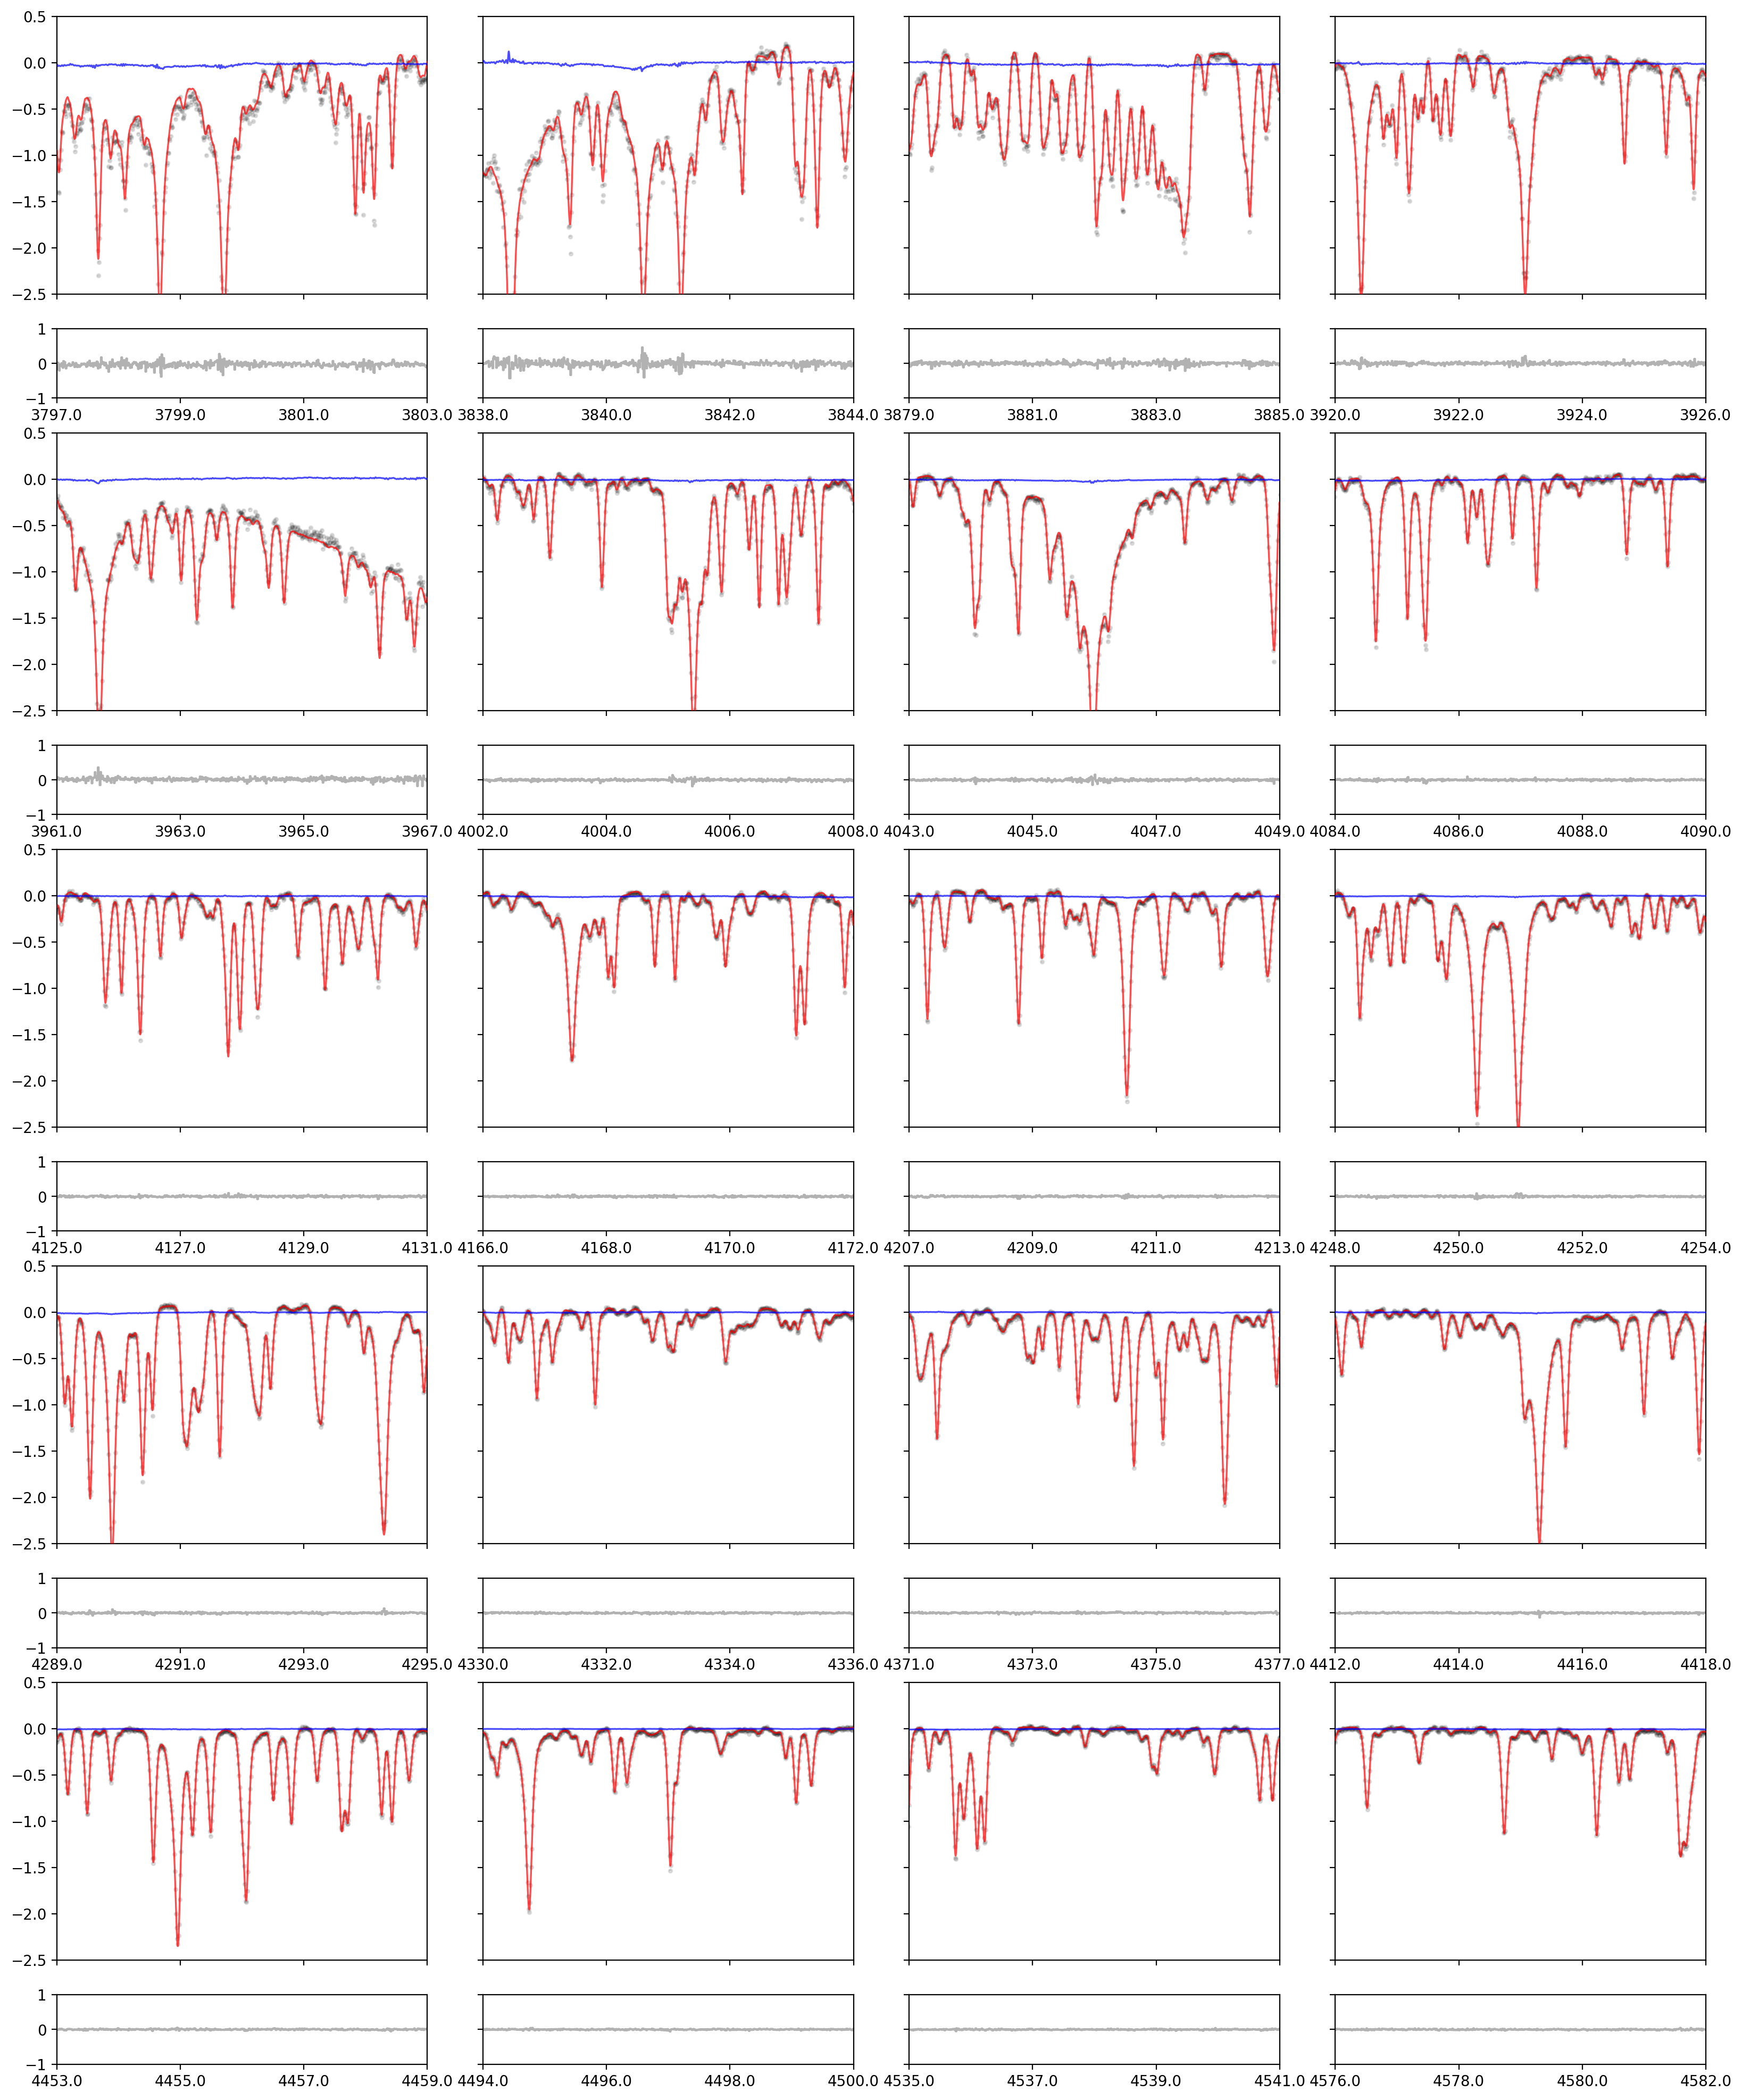

In [27]:
# (datasets,models,size_n,size_m,plt_epochs,orders)
order_list = [np.min(np.concatenate(dataset.xs)) for dataset in all_data]
# print(order_list)
ordered_order_list = np.array(np.argsort(order_list))
# print(ordered_order_list)
size_m = 5
size_n = 4
plt_epochs = np.zeros((size_m*size_n),dtype=int)

jabble.plotting.make_grid_plots([all_data[xx] for xx in ordered_order_list],[all_models[xx] for xx in ordered_order_list],\
                                size_m,size_n,plt_epochs,cpus[0],\
                                plt_name="{}_pre_norm_{}-{}.png".format(star_name,plt_epochs.min(),plt_epochs.max()),out_dir=out_dir)

In [28]:
def make_norm_plot(model,dataset,plt_epoches,lmin,lmax,lrange,plt_name):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex=True,sharey='row',facecolor=(1, 1, 1),dpi=200)
    
    x_window = np.log(4550) - np.log(4549)
    
    model.fix()
    for ii, plt_epoch in enumerate(plt_epoches):
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
        yplot = model[0]([],xplot,plt_epoch)
        yplot_norm_tell = model[1][1]([],xplot,plt_epoch)
        yplot_norm_stel = model[1][0]([],xplot,plt_epoch)
        yhat = model[0]([],dataset.xs[plt_epoch],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())
        
        
    
        
        axes[0,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
        
        axes[0,ii].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
     
        axes[1,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        # axes[1,ii].plot(gas_xs,gas_ys,'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        
        axes[1,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[1,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[0,ii].set_xticks([])
        axes[1,ii].set_xticks(np.log(lrange))
        axes[1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        # axes[0,ii].set_ylims()
        # axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),'.k',alpha=0.4,ms=1)
        
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    plt.savefig(plt_name,dpi=300,bbox_inches='tight')
    plt.show()

60
[[6275. 6277. 6279. 6281. 6283.]
 [6275. 6277. 6279. 6281. 6283.]]


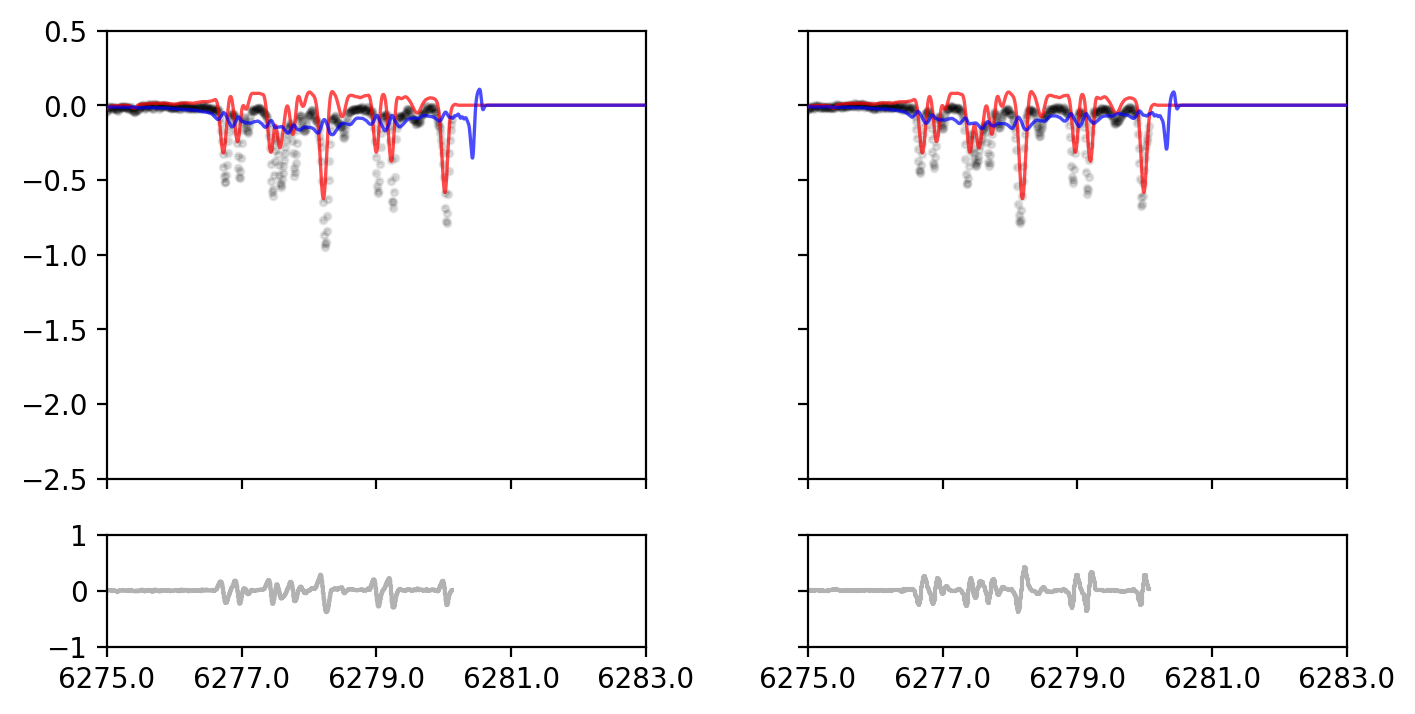

In [31]:
lmin = np.array([np.min(np.exp(data.xs)) for data in all_data])
lmax = np.array([np.max(np.exp(data.xs)) for data in all_data])
l_plt = 6280

model_indice, = np.where((l_plt > lmin)*(l_plt < lmax))
model_index = model_indice[0]
print(model_index)
rv_inds = [-1,0]
# rv_data = jabble.physics.velocities(all_models[jjj][0][0].p)
# print(all_models[model_index].metadata.keys())


# dataset, _, _, _, _ = get_dataset(file_b,orders,cpus[0])
# ls_means = np.ceil([np.exp(all_data[model_index].xs[xxx][:]) for xxx in rv_inds]).mean(axis=1)
lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-5,5,2)[None,:]
# print(lrange)
# lrange = np.repeat(lrange,len(rv_inds),axis=0) + np.zeros(len(rv_inds))[:,None]
plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
print(lrange)
jabble.plotting.make_order_plot(all_data[model_index],all_models[model_index],lrange,rv_inds,cpus[0],plt_name)
#(dataset,model,lrange,rv_inds,device,plt_name=None)

In [ ]:
plt_epoches= [0,1,2]
lmin = np.exp(data.xs[0][1000])
lmax = np.exp(data.xs[0][7000])
lrange = np.arange(lmin,lmax,10)
plt_names = [os.path.join(out_dir,'04-18sco-norm-stel-tell-{}_{}-npt{}.png'.format(np.min(lrange),np.max(lrange),norm_pt))
    for norm_pt in norm_pts]
for norm_model,plt_name in zip(norm_models,plt_names):
    make_norm_plot(norm_model,data,plt_epoches,lmin,lmax,lrange,plt_name)

In [ ]:
9999*196

In [ ]:
p = pstats.Stats(statsname)
p.sort_stats(SortKey.TIME).print_stats(10)